In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from time import time 
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")



# EDA class
Here we define a class to replace common EDA functions such as corr(), scatter(), hist(), and histogram()

In [2]:
from dataheroes.core.sklearn_extra import WPCA
from dataheroes import CoresetTreeServicePCA,CoresetTreeServiceKMeans
from numpy.core.umath import sqrt
from numpy.lib.twodim_base import diag
import pandas as pd
import numpy as np

class CoresetEDA(object):
    def __init__(self,X,y=None,coreset_size=2000):
        """
        Initialize a coreset based EDA.
        X - a DataFrame structure of the data features.
        y - a DataFrame structure of the data target, default None.
        coreset_size - size of the coreset size, default 2,000 .
        """
        if y is not None: # if y exist concatenate with [X,y]
            self.columns = list(X.columns) + [y.name]            
            self.X = pd.concat([X,y],axis=1)
        else:
            self.columns = X.columns
            self.X = X
        # create PCA coreset
        self.core_pca = CoresetTreeServicePCA(optimized_for="training",coreset_size=coreset_size,chunk_size=-1)
        self.core_pca.build(self.X.values)
        # create K-Means coreset
        self.core_km = CoresetTreeServiceKMeans(optimized_for="training",coreset_size=coreset_size,chunk_size=-1)
        self.core_km.build(X.values)

        # Grab indices and weights
        data = self.core_pca.get_coreset()
        self.PCA = {}
        self.PCA["ind"] = data["data"][0]
        self.PCA["w"] = data["w"]
        data = self.core_km.get_coreset()
        self.KM = {}
        self.KM["ind"] = data["data"][0]
        self.KM["w"] = data["w"]


    def corr(self):
        """
        Compute correlation
        Return: correlation matrix as DataFrame
        """
        wpca = WPCA()
        ind = self.PCA["ind"]
        w = self.PCA["w"]
        x = self.X.iloc[ind,:]
        columns = self.X.columns
        # compute PCA
        wpca.fit(x,sample_weight = w)
        # compute covariance
        c = wpca.get_covariance()
        # scale covariance to correlation
        d = diag(c)
        stddev = sqrt(d.real)
        c /= stddev[:, None]
        c /= stddev[None, :]
        if type(self.X) == pd.DataFrame:
            c = pd.DataFrame(c, index = columns, columns = columns)
        return c
    
    def hist(self,col=None,**kagrs):
        """
        Plot histogram
        col - column to compute, default None if None compute for all features
        return histogram plots
        """
        ind = self.KM["ind"]
        w = self.KM["w"]
        if col is None:
            return self.X.iloc[ind,:].hist(weights=w,**kagrs)
        return self.X.iloc[ind].hist(column = col,weights=w,**kagrs)
    
    def histogram(self,col=None,**kagrs):
        """
        Compute histogram
        col - column to compute, default None if None compute for all features
        return histogram array
        """
        ind = self.KM["ind"]
        w = self.KM["w"]
        if type(self.X) == pd.DataFrame:
            if col is not None:
                return np.histogram(self.X[col].iloc[ind],weights = w,**kagrs)
            res = {}
            for k in self.X.columns:
                res[k] = np.histogram(self.X[k].iloc[ind],weights = w,**kagrs)
        else:
            if col is not None:
                return np.histogram(self.X[ind,col],weights = w,**kagrs)
            res = []
            for c in range(self.X.shape[1]):
                res.append(np.histogram(self.X[ind,c],weights = w,**kagrs))
            res = np.array(res)
        return res
    
    
    def scatter(self,col1,col2,**kagrs):
        ind = self.PCA["ind"]
        w = self.PCA["w"]
        return self.X.iloc[ind].plot.scatter(x=col1,y=col2,s=w,**kagrs)

            
        

# Data Load
Here we load the 50M samples of the criteo dataset (only numerical features). 

We select a coreset size

In [3]:
from pathlib import Path
import gdown
import shutil

data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)
if (not data_dir.is_file()):
    # We already processed the dataset and stored it on google drive so we are going to download it from there because it is faster
    gdown.download_folder('https://drive.google.com/drive/folders/1evltfEN5ulC3cSXpcRHAHIHxoQmRrl_M', output=data_dir.as_posix(), quiet=False,remaining_ok=True)

import zipfile
with zipfile.ZipFile("data/Criteo_numerical_EDA.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")  
    

Retrieving folder contents


Processing file 1ULbZVd1_bw9FJKQEznf7JKMwJzheFizj Criteo_numerical_EDA.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1ULbZVd1_bw9FJKQEznf7JKMwJzheFizj
From (redirected): https://drive.google.com/uc?id=1ULbZVd1_bw9FJKQEznf7JKMwJzheFizj&confirm=t&uuid=42c98a39-91cd-419f-b96c-55c06a40caaf
To: /home/ubuntu/PoC/coresets-rd/EDA/data/Criteo_numerical_EDA.zip
100%|██████████| 734M/734M [00:08<00:00, 87.8MB/s] 
Download completed


In [4]:
X = pd.read_csv("data/Criteo_numerical_EDA.csv",index_col=[0])

In [5]:
coreset_size = 200_000
print("Dataset size:",X.shape)
print("Coreset size:",coreset_size)
results = {}

Dataset size: (50000000, 13)
Coreset size: 200000


## Coreset Build

In [6]:
t = time()
eda = CoresetEDA(X,None,coreset_size=coreset_size)
print("Time to build the coreset ",round(time() - t,3))

Time to build the coreset  114.43


# Correlation heatmap

## Full data

In [7]:
results["Corr"] = {}
t = time()
corr = X.corr()
results["Corr"]["Full"] = str(round(time() - t,3))+" seconds"
print("Time to compute the correlation of the full data ",time() - t)

Time to compute the correlation of the full data  26.275599241256714


## Coreset

In [8]:
t = time()
corr_coreset = eda.corr()
results["Corr"]["Coreset"] = str(round(time() - t,3)) + " seconds"
print("Time to compute the correlation of the coreset ",time() - t)

Time to compute the correlation of the coreset  0.11980175971984863


## Visual Comparison

Text(0.5, 1.0, 'Coreset')

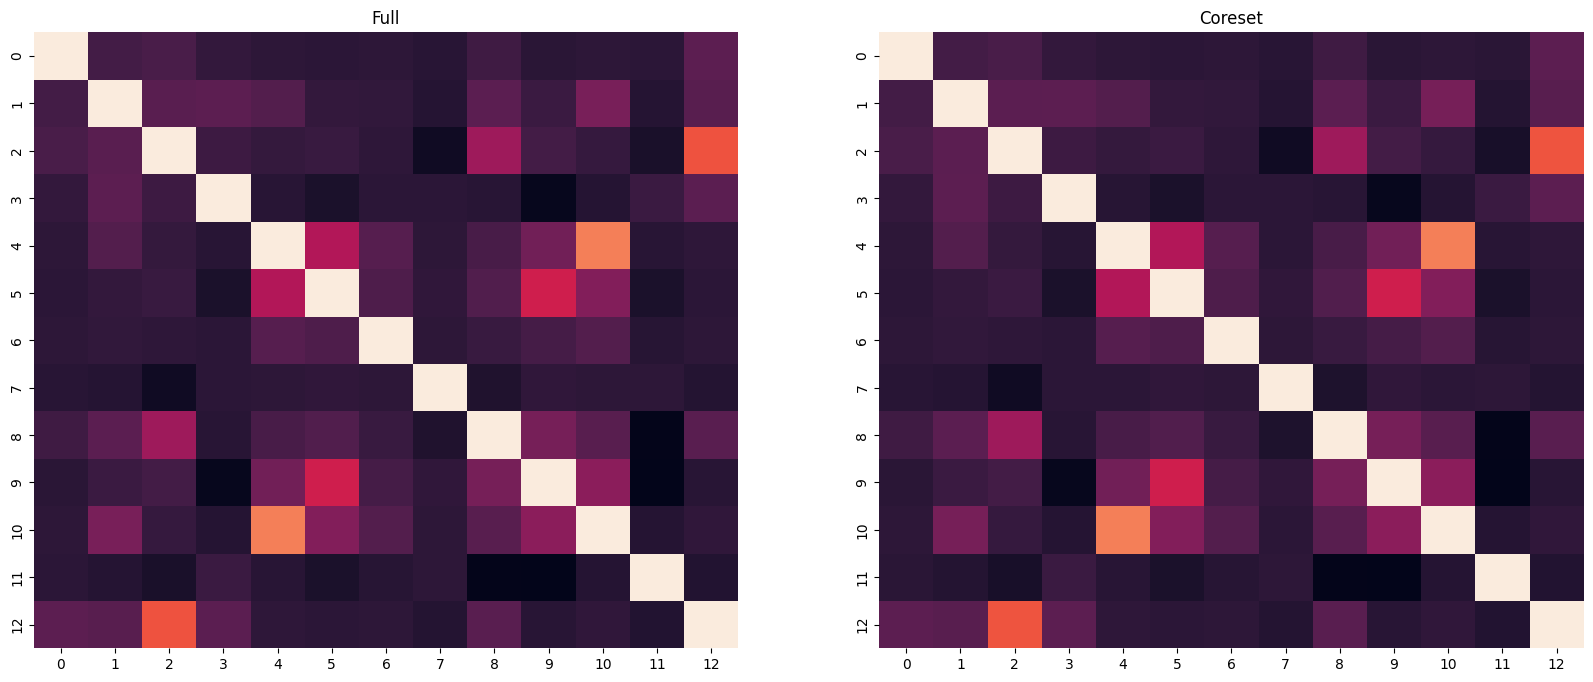

In [9]:
fig, axes = plt.subplots(1, 2,figsize=(20, 8))
sns.heatmap(corr,ax=axes[0],cbar=False)
axes[0].set_title('Full')
sns.heatmap(corr_coreset,ax=axes[1],cbar=False)
axes[1].set_title('Coreset')


# Histogram

## Full

In [10]:
results["Histogram"] = {}
t = time()
hist_full = []
for k in X.columns:
    hist_full.append(np.histogram(X[k],bins=50))

results["Histogram"]["Full"] = str(round(time() - t,3)) +" seconds"
print("Time to compute the histogram of the full data",round(time() - t,3),"s")

Time to compute the histogram of the full data 10.784 s


## Coreset

In [11]:
t = time()
temp = eda.histogram(bins=50)
hist_coreset = []
results["Histogram"]["Coreset"] = str(round(time() - t,3)) +" seconds"
print("Time to compute the histogram of the coreset data",round(time() - t,3),"s")

Time to compute the histogram of the coreset data 0.163 s


## Visual Comparison

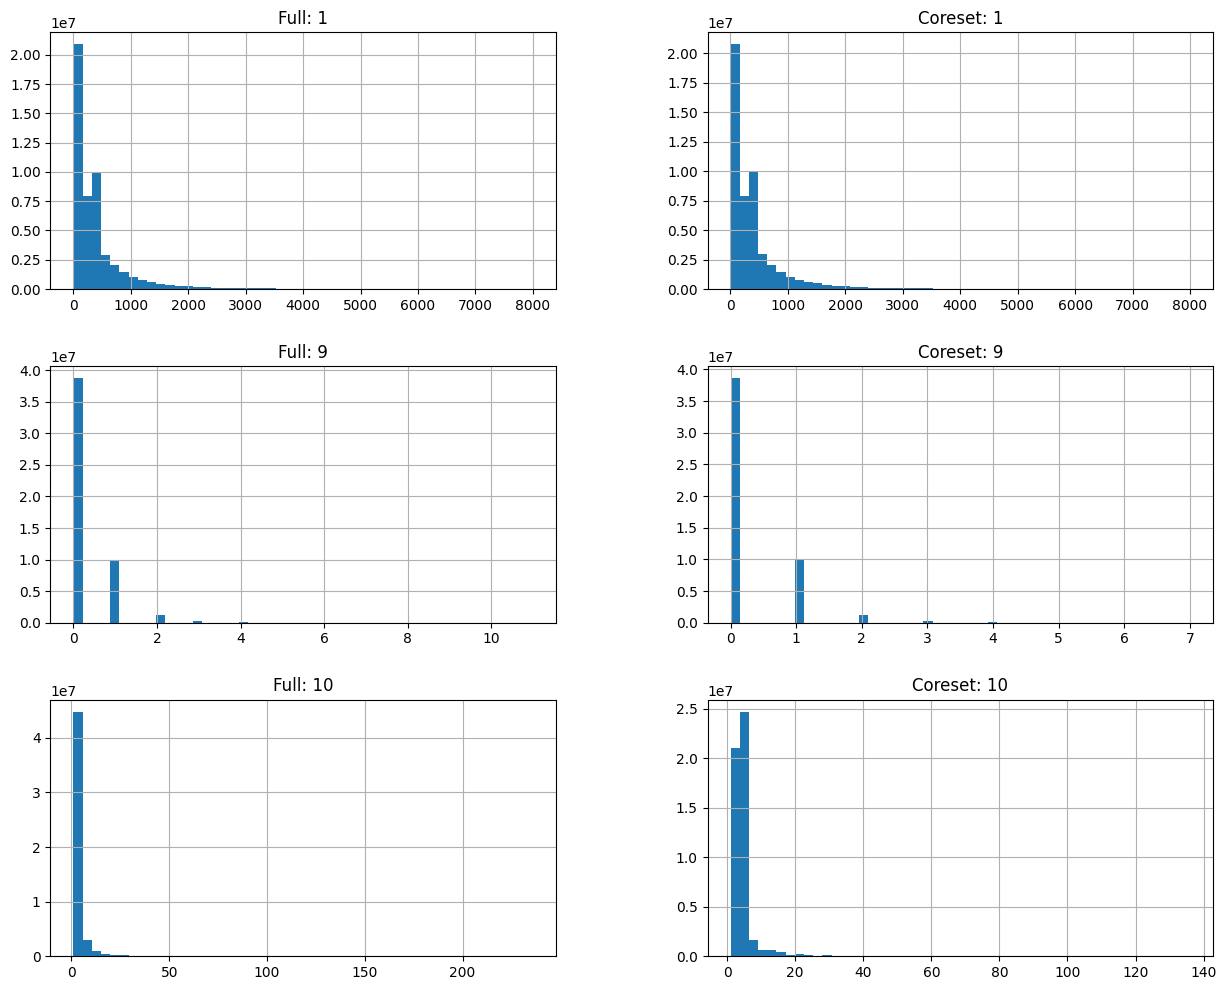

In [12]:
col = ["1","9","10"]
fig, axes = plt.subplots(len(col), 2,figsize=(15, 4*len(col)))
i = 0
for c in col:
    X.hist(column= c,bins=50,ax= axes[i,0])
    eda.hist(col=c,bins=50,ax=axes[i,1])
    #if i == 0:
    axes[i,0].set_title('Full: ' + str(c))
    axes[i,1].set_title('Coreset: '+ str(c))
    i+=1

# Scatter Plot

## Full

In [13]:
col1,col2 = ["0","1","2"],["1","2","12"]

<Axes: xlabel='0', ylabel='1'>

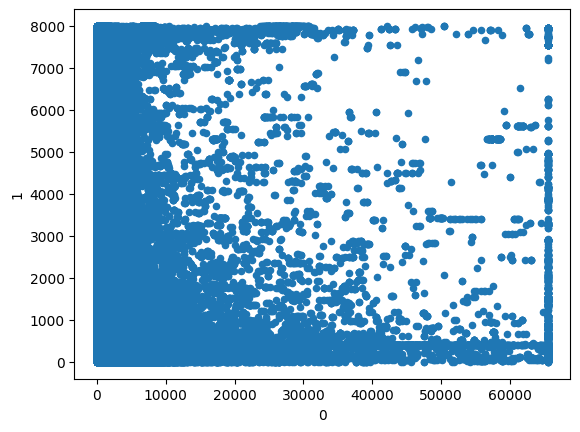

In [14]:
results["scatter"] = {}
t = time()
X.plot.scatter(x=col1[0],y=col2[0])

In [15]:
time_render = time() - t
results["scatter"]["Full"] = str(round(time_render,3))+ " seconds"
print("Time to plot the scatter of the full data",round(time_render,3),"s")

Time to plot the scatter of the full data 135.253 s


## Coreset

<Axes: xlabel='0', ylabel='1'>

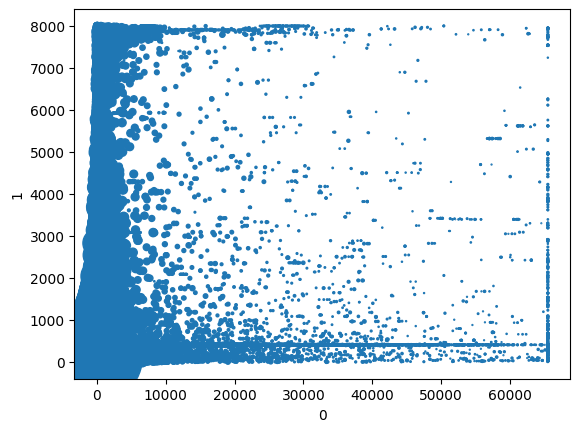

In [16]:
t = time()
eda.scatter(col1[0],col2[0])


In [17]:
time_render = time() - t
results["scatter"]["Coreset"] = str(round(time_render,3)) +" seconds"
print("Time to plot the scatter of the coreset data",round(time_render,3),"s")

Time to plot the scatter of the coreset data 11.652 s


## Visual comparison

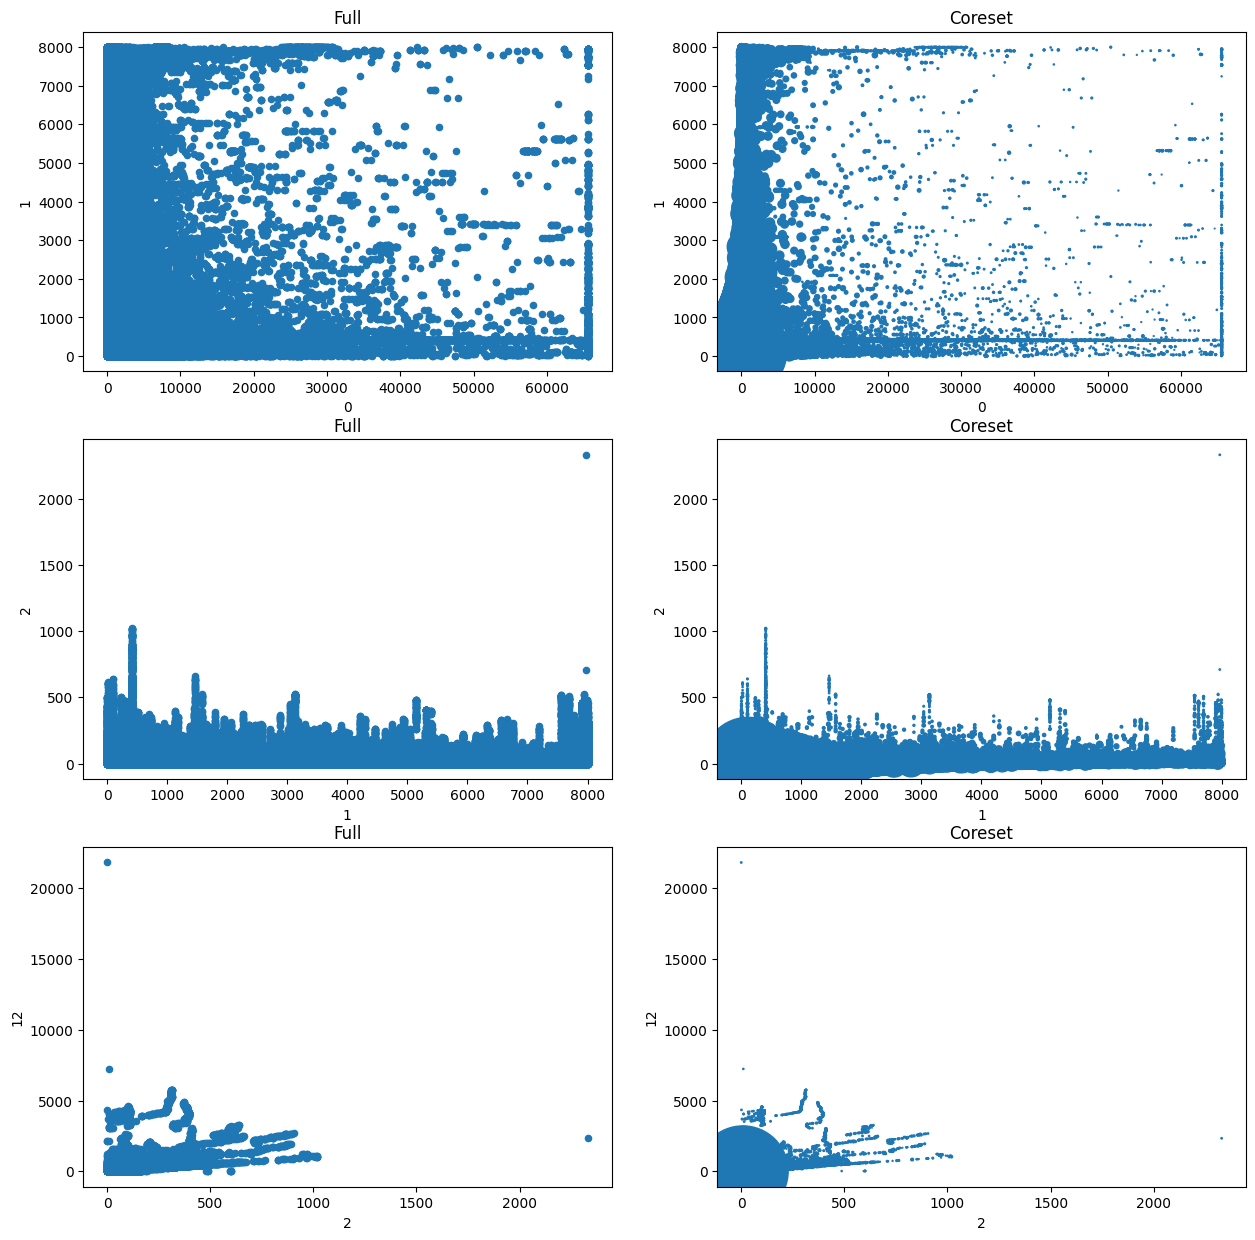

In [18]:
fig, axes = plt.subplots(len(col1), 2,figsize=(15, 5*len(col1)))
i = 0
for c1,c2 in zip(col1,col2):
    X.plot.scatter(x=c1,y=c2,ax= axes[i,0])
    eda.scatter(c1,c2,ax=axes[i,1])
    axes[i,0].set_title('Full')
    axes[i,1].set_title('Coreset')    
    i+=1

# Compare run time of Full data vs DataHeroes Coreset
##### We used an ec2 m5.4xlarge instance for running the notebook

In [19]:
pd.DataFrame(results)

,Corr,Histogram,scatter
Full,26.276 seconds,10.784 seconds,135.253 seconds
Coreset,0.12 seconds,0.163 seconds,11.652 seconds
